In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings("ignore")

In [9]:
kp_df = pd.read_csv(
    './datasets/kp.csv',
    sep='\s+',  # Está separado com espaço em branco
    header=None,
    parse_dates={'Datetime': [0, 1, 2, 3]},  # Especifica as colunas a serem combinadas para formar a coluna Datetime
    date_parser=lambda x: pd.to_datetime(x, format='%Y %m %d %H.%M')
)

kp_df.set_index('Datetime', inplace=True)

In [10]:
arquivos_csv = [
    './datasets/dsc_fc_summed_spectra_2017_v01.csv',
    './datasets/dsc_fc_summed_spectra_2018_v01.csv',
    './datasets/dsc_fc_summed_spectra_2019_v01.csv',
    './datasets/dsc_fc_summed_spectra_2020_v01.csv',
    './datasets/dsc_fc_summed_spectra_2021_v01.csv',
    './datasets/dsc_fc_summed_spectra_2022_v01.csv',
    './datasets/dsc_fc_summed_spectra_2023_v01.csv'
]

dfs = [pd.read_csv(arquivo, parse_dates=[0], header=None).fillna(0) for arquivo in arquivos_csv]
df = pd.concat(dfs, ignore_index=True)
df.set_index(df.columns[0], inplace=True)

In [11]:
# Linhas e Colunas
df.shape

(2993760, 53)

In [12]:
# Resample para colocar os dados em formato de hora em hora
df = df.resample('H').median()

In [13]:
# Linhas e Colunas
df.shape

(55512, 53)

#### Merge dos dataframes
- KP: detalhes sobre magnetismo solar
- Spectra: detalhes sobre vento solar

In [14]:
df.columns = df.columns.astype(str)
kp_df.columns = kp_df.columns.astype(str)

df = df.merge(kp_df, how='inner', left_index=True, right_index=True)

### Identificação da quantidade de componentes necessários para explicar pelo menos 80% da variância acumulada

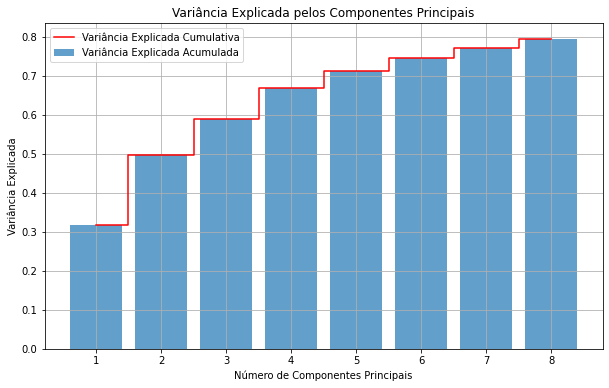

In [18]:
# Identificação de colunas com um percentual alto de valores nulos (50% neste caso)
limiar_percentual_nulos = 0.5
colunas_com_muitos_nulos = df.columns[df.isnull().median() > limiar_percentual_nulos]

# Remoção das colunas com muitos valores nulos
df = df.drop(columns=colunas_com_muitos_nulos)

# Imputação dos valores NaN a partir da mediana
imputer = SimpleImputer(strategy='median')
df_imputado = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)

# Padronize dos dados
scaler = StandardScaler()
df_padronizado = pd.DataFrame(scaler.fit_transform(df_imputado), columns=df_imputado.columns, index=df_imputado.index)

# Aplicação do PCA para redução de dimensionalidade
num_componentes = 8  # Número definido com base na variância explicada > 80% (testado anteriormente)
pca = PCA(n_components=num_componentes)
df_reduzido = pd.DataFrame(pca.fit_transform(df_padronizado), columns=[f'PC{i+1}' for i in range(num_componentes)], index=df_padronizado.index)
variância_explicada = np.cumsum(pca.explained_variance_ratio_)

# Gráfico de barras para visualizar a variância explicada
plt.figure(figsize=(10, 6))
plt.bar(range(1, num_componentes + 1), variância_explicada, alpha=0.7, align='center', label='Variância Explicada Acumulada')
plt.step(range(1, num_componentes + 1), variância_explicada, where='mid', label='Variância Explicada Cumulativa', color='red')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada')
plt.legend(loc='best')
plt.title('Variância Explicada pelos Componentes Principais')
plt.grid(True)
plt.show()

In [19]:
# Nome do modelo usado para checkpoint
checkpoint_path = "melhor_modelo.h5"

# Callback ModelCheckpoint para monitorar a métrica e salvar o melhor modelo
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Monitora a acurácia
    save_best_only=True,      # Salva apenas o melhor modelo
    mode='max',               # Salva com base no aumento da métrica
    verbose=1
)

limiar_anomalia = 2.0

# Label anomalia (0 para não, 1 para sim)
df_reduzido['anomalia'] = np.where(df_reduzido['PC1'] > limiar_anomalia, 1, 0)

# Separação dos dados X e y (target)
X = df_reduzido.drop(columns=['anomalia']).values
y = df_reduzido['anomalia'].values

# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criação do modelo de classificação
model = Sequential()
model.add(Dense(64, input_dim=num_componentes, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Saída binária (0 ou 1) para classificação de anomalias

# Compilação do modelo
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

# Treinamento com o callback ModelCheckpoint
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,     # conjunto de validação
    callbacks=[model_checkpoint]  # callback ModelCheckpoint
)

# Carregamento do melhor modelo salvo
melhor_modelo = load_model(checkpoint_path)

# Avaliação do melhor modelo
y_pred_melhor = melhor_modelo.predict(X_test)
y_pred_melhor = (y_pred_melhor > 0.5)  # Threshold para converter para 0 ou 1


Epoch 1/50
368/371 [============================>.] - ETA: 0s - loss: 0.0925 - accuracy: 0.9733
Epoch 1: val_accuracy improved from -inf to 0.98413, saving model to melhor_modelo.h5
371/371 [==============================] - 2s 3ms/step - loss: 0.0921 - accuracy: 0.9733 - val_loss: 0.0367 - val_accuracy: 0.9841
Epoch 2/50
351/371 [===========================>..] - ETA: 0s - loss: 0.0257 - accuracy: 0.9913
Epoch 2: val_accuracy improved from 0.98413 to 0.99189, saving model to melhor_modelo.h5
371/371 [==============================] - 1s 2ms/step - loss: 0.0255 - accuracy: 0.9911 - val_loss: 0.0234 - val_accuracy: 0.9919
Epoch 3/50
344/371 [==========================>...] - ETA: 0s - loss: 0.0207 - accuracy: 0.9926
Epoch 3: val_accuracy did not improve from 0.99189
371/371 [==============================] - 1s 2ms/step - loss: 0.0204 - accuracy: 0.9926 - val_loss: 0.0208 - val_accuracy: 0.9919
Epoch 4/50
364/371 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.99

371/371 [==============================] - 1s 2ms/step - loss: 0.0090 - accuracy: 0.9965 - val_loss: 0.0139 - val_accuracy: 0.9953
Epoch 30/50
365/371 [============================>.] - ETA: 0s - loss: 0.0078 - accuracy: 0.9967
Epoch 30: val_accuracy did not improve from 0.99527
371/371 [==============================] - 1s 2ms/step - loss: 0.0077 - accuracy: 0.9967 - val_loss: 0.0224 - val_accuracy: 0.9919
Epoch 31/50
355/371 [===========================>..] - ETA: 0s - loss: 0.0092 - accuracy: 0.9960
Epoch 31: val_accuracy did not improve from 0.99527
371/371 [==============================] - 1s 2ms/step - loss: 0.0089 - accuracy: 0.9962 - val_loss: 0.0160 - val_accuracy: 0.9943
Epoch 32/50
347/371 [===========================>..] - ETA: 0s - loss: 0.0078 - accuracy: 0.9968
Epoch 32: val_accuracy did not improve from 0.99527
371/371 [==============================] - 1s 2ms/step - loss: 0.0080 - accuracy: 0.9967 - val_loss: 0.0148 - val_accuracy: 0.9943
Epoch 33/50
352/371 [========

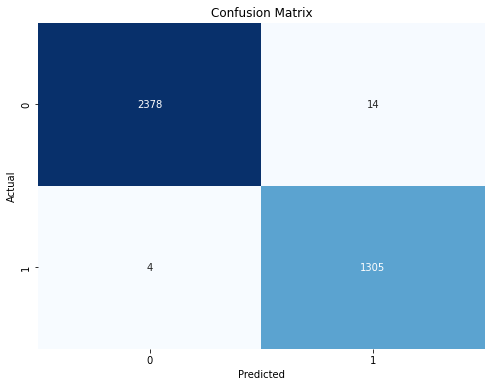

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2392
           1       0.99      1.00      0.99      1309

    accuracy                           1.00      3701
   macro avg       0.99      1.00      0.99      3701
weighted avg       1.00      1.00      1.00      3701



In [20]:
conf_matrix = confusion_matrix(y_test, y_pred_melhor)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Métricas de classificação
print(classification_report(y_test, y_pred_melhor))